###################### ESCOLHA DO MODELO ########################################


,Description,Value
0,Session id,5558
1,Target,shot_made_flag
2,Target type,Binary
3,Original data shape,"(16228, 7)"
4,Transformed data shape,"(16228, 7)"
5,Transformed train set shape,"(11359, 7)"
6,Transformed test set shape,"(4869, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5995,0.5000,0.5249,0.5913,0.5561,0.1936,0.1947
1,0.5739,0.5000,0.4899,0.5624,0.5236,0.1416,0.1427
2,0.5599,0.5000,0.4631,0.5457,0.5010,0.1120,0.1132
3,0.5827,0.5000,0.5074,0.5705,0.5371,0.1597,0.1606
4,0.5616,0.5000,0.4649,0.5478,0.5030,0.1155,0.1168
5,0.5757,0.5000,0.4760,0.5658,0.5170,0.1437,0.1454
6,0.5757,0.5000,0.4834,0.5647,0.5209,0.1442,0.1456
7,0.5960,0.5000,0.5111,0.5881,0.5469,0.1855,0.1870
8,0.5801,0.5000,0.4815,0.5711,0.5225,0.1526,0.1544


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5995,0.5000,0.5249,0.5913,0.5561,0.1936,0.1947
1,0.5739,0.5000,0.4899,0.5624,0.5236,0.1416,0.1427
2,0.5599,0.5000,0.4631,0.5457,0.5010,0.1120,0.1132
3,0.5827,0.5000,0.5074,0.5705,0.5371,0.1597,0.1606
4,0.5616,0.5000,0.4649,0.5478,0.5030,0.1155,0.1168
5,0.5757,0.5000,0.4760,0.5658,0.5170,0.1437,0.1454
6,0.5757,0.5000,0.4834,0.5647,0.5209,0.1442,0.1456
7,0.5960,0.5000,0.5111,0.5881,0.5469,0.1855,0.1870
8,0.5801,0.5000,0.4815,0.5711,0.5225,0.1526,0.1544


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5528,0.4930,0.5948,0.5286,0.5598,0.1086,0.1094
1,0.5202,0.4984,0.5451,0.4983,0.5207,0.0424,0.0426
2,0.5379,0.5024,0.5867,0.5137,0.5478,0.0795,0.0802
3,0.5387,0.5008,0.5830,0.5147,0.5467,0.0809,0.0815
4,0.5467,0.4833,0.5793,0.5225,0.5494,0.0957,0.0962
5,0.5651,0.4883,0.5720,0.5420,0.5566,0.1306,0.1307
6,0.5317,0.4931,0.5830,0.5080,0.5430,0.0674,0.0681
7,0.5379,0.5101,0.5683,0.5142,0.5399,0.0780,0.0784
8,0.5352,0.4885,0.5461,0.5121,0.5286,0.0712,0.0713


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6021,0.5000,0.3867,0.6383,0.4817,0.1892,0.2049
1,0.5960,0.5000,0.3738,0.6304,0.4694,0.1762,0.1919
2,0.5766,0.5000,0.3173,0.6078,0.4170,0.1333,0.1507
3,0.5995,0.5000,0.3727,0.6372,0.4703,0.1824,0.1994
4,0.5783,0.5000,0.3524,0.5987,0.4437,0.1394,0.1522
5,0.5933,0.5000,0.3376,0.6399,0.4420,0.1677,0.1890
6,0.5898,0.5000,0.3653,0.6188,0.4594,0.1628,0.1776
7,0.6021,0.5000,0.3875,0.6364,0.4817,0.1887,0.2040
8,0.5889,0.5000,0.3395,0.6280,0.4407,0.1592,0.1781


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.5929,0.4977,0.3930,0.6150,0.4791,0.1712,0.1828,0.0470
gbc,Gradient Boosting Classifier,0.5888,0.5037,0.4010,0.6044,0.4818,0.1636,0.1732,0.1040
ridge,Ridge Classifier,0.5792,0.0000,0.4932,0.5680,0.5279,0.1518,0.1530,0.0080
lda,Linear Discriminant Analysis,0.5792,0.5000,0.4934,0.5680,0.5280,0.1518,0.1530,0.0090
lr,Logistic Regression,0.5788,0.5000,0.4921,0.5677,0.5271,0.1510,0.1523,0.0080
nb,Naive Bayes,0.5776,0.5000,0.5129,0.5630,0.5367,0.1502,0.1507,0.0080
qda,Quadratic Discriminant Analysis,0.5773,0.5000,0.5387,0.5594,0.5488,0.1516,0.1517,0.0090
lightgbm,Light Gradient Boosting Machine,0.5736,0.5114,0.4851,0.5618,0.5204,0.1402,0.1415,0.1810
svm,SVM - Linear Kernel,0.5707,0.0000,0.5317,0.5538,0.5400,0.1383,0.1396,0.0120
rf,Random Forest Classifier,0.5557,0.5290,0.5214,0.5355,0.5282,0.1085,0.1086,0.1570


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

Média da pontuação da validação cruzada para regressão logística: 0.5769653488422872
##############################################################


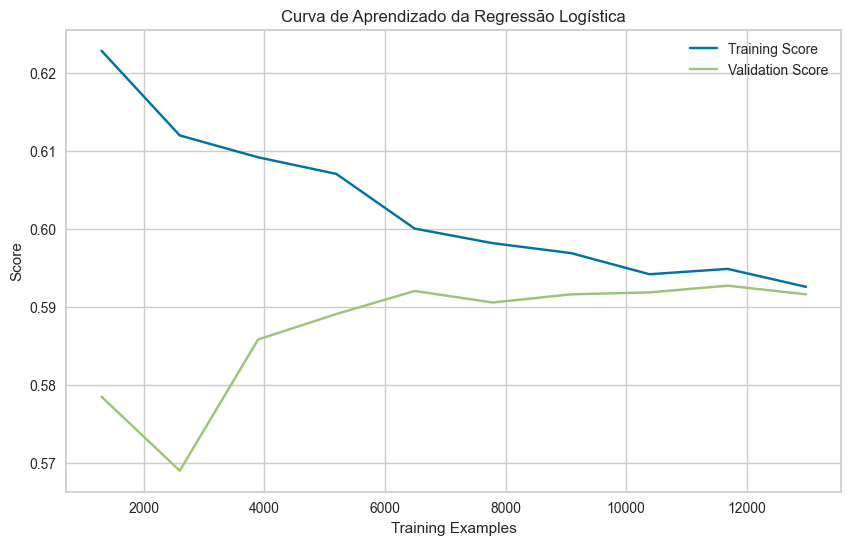

##############################################################


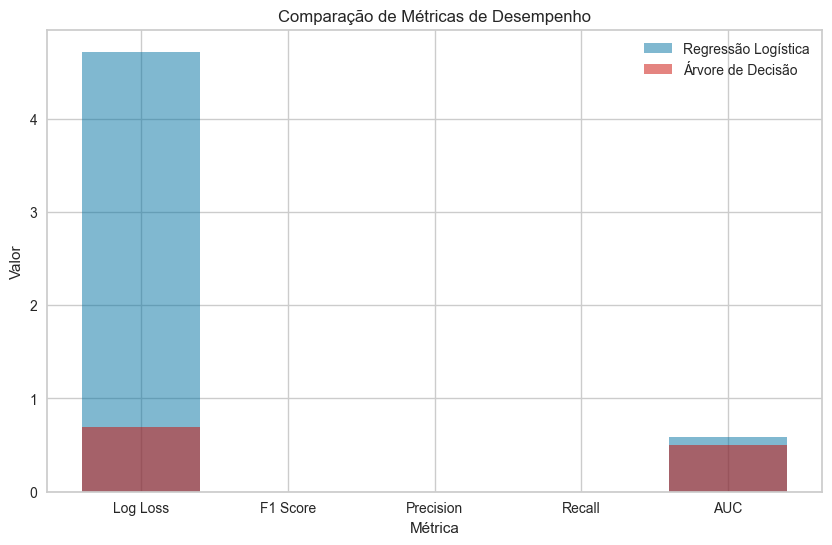

##############################################################
O melhor modelo selecionado foi: Árvore de Decisão
##############################################################
Importância das Variáveis para Árvore de Decisão:
                   Importance
shot_distance             1.0
lat                       0.0
lon                       0.0
minutes_remaining         0.0
period                    0.0
playoffs                  0.0
##############################################################
Verdadeiro Positivo (VP): 0
Falso Positivo (FP): 0
Verdadeiro Negativo (VN): 2120
Falso Negativo (FN): 1937


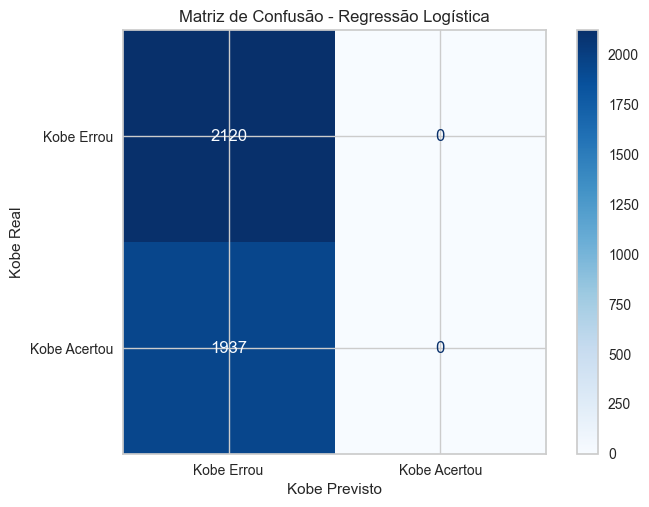

##############################################################


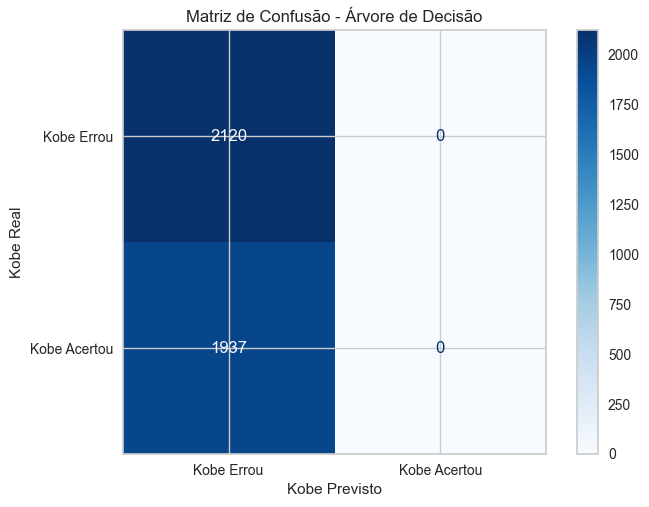

##############################################################


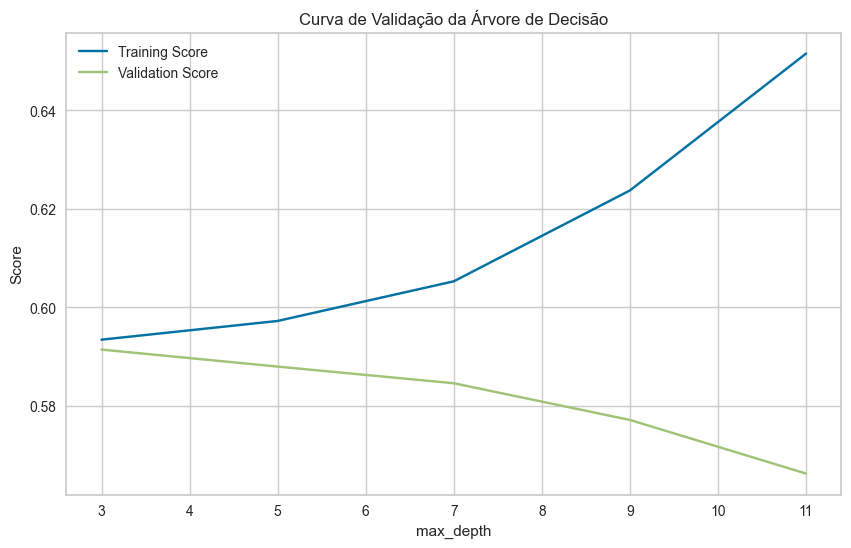

##############################################################
Classification Report:
              precision    recall  f1-score   support

           0       0.52      1.00      0.69      2120
           1       0.00      0.00      0.00      1937

    accuracy                           0.52      4057
   macro avg       0.26      0.50      0.34      4057
weighted avg       0.27      0.52      0.36      4057

Resultados detalhados:
                 Model  Accuracy  Precision  Recall  F1 Score  Log Loss  \
0  Regressão Logística  0.522554        0.0     0.0       0.0  4.719524   
1    Árvore de Decisão  0.522554        0.0     0.0       0.0  0.698790   

       AUC  
0  0.59176  
1  0.50000  
O melhor modelo selecionado é: Árvore de Decisão
############################### AUC ROC ###############################
AUC da curva ROC para Regressão Logística: 0.5917595289350386
AUC da curva ROC para Árvore de Decisão: 0.5


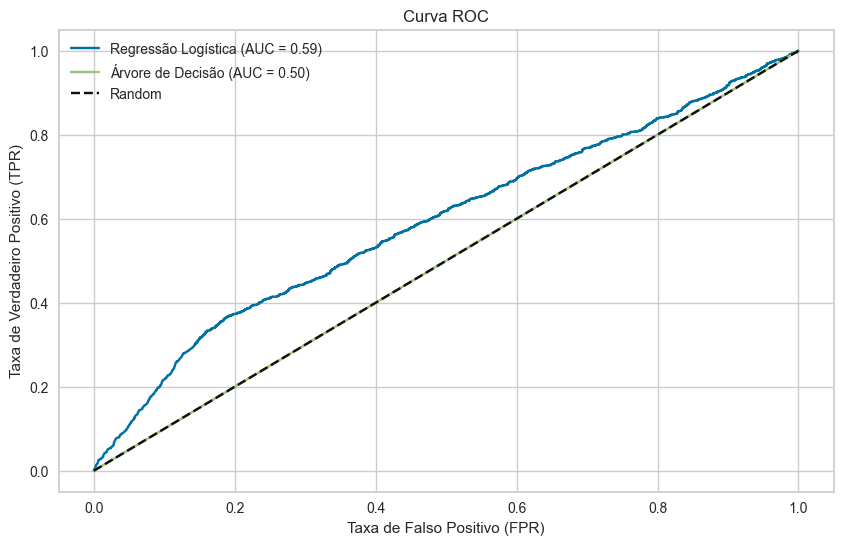

O modelo selecionado para a solução é: Regressão Logística


['../../data/modeling/models/model.pkl']

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, validation_curve
from sklearn.metrics import classification_report, confusion_matrix, log_loss, f1_score, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
import mlflow
import shutil
from pycaret.classification import *
import matplotlib.pyplot as plt
import joblib

# Definir a função para divisão de dados
def split_data(data, test_size=0.2):
    """
    Função para dividir os dados em conjuntos de treino e teste.
    """
    # Target
    y = data['shot_made_flag']
    # Features 
    X = data.drop('shot_made_flag', axis=1)
    
    # Dividir os dados de forma aleatória e estratificada
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)
    
    return X_train, X_test, y_train, y_test

# Definir diretório de execução do MLflow
mlflow.set_tracking_uri("file:///../../data/modeling/tracking/mlruns")

# Verificar se o experimento existe, senão, criar
mlflow.set_experiment("Treinamento")

# Iniciar o experimento do MLflow
with mlflow.start_run(run_name="Treinamento"):
    
    # Carregar os dados pré-processados de desenvolvimento
    data_file = "../../data/processed/data_filtered.parquet"
    df_kobe = pd.read_parquet(data_file)

    # Definir as features e o target
    X_train, X_test, y_train, y_test = split_data(df_kobe)

    
    print("###################### ESCOLHA DO MODELO ########################################")
    
    # Configurar o ambiente PyCaret
    setup(data=pd.concat([X_train, y_train], axis=1), target='shot_made_flag', normalize=True, log_experiment=False)

    # Treinar um modelo de regressão logística
    lr_model = create_model('lr')

    # Calibrar o modelo de regressão logística
    tuned_lr_model = tune_model(lr_model)

    # Treinar um modelo de árvore de decisão
    dt_model = create_model('dt')

    # Calibrar o modelo de árvore de decisão
    tuned_dt_model = tune_model(dt_model)
    
    # Comparar os modelos treinados
    compare_models()

    # Calcular a validação cruzada para o modelo de regressão logística
    lr_cv_scores = cross_val_score(tuned_lr_model, X_train, y_train, cv=5, scoring='accuracy')

    # Calcular a média das pontuações da validação cruzada para regressão logística
    mean_lr_cv_score = lr_cv_scores.mean()
    
    print("Média da pontuação da validação cruzada para regressão logística:", mean_lr_cv_score)
    
    # Calcular a validação cruzada para o modelo de árvore de decisão
    dt_cv_score = cross_val_score(tuned_dt_model, X_train, y_train, cv=5, scoring='accuracy').mean()

    # Selecionar o melhor modelo com base na validação cruzada
    best_model = tuned_lr_model if mean_lr_cv_score > dt_cv_score else tuned_dt_model

    # Salvar o modelo usando o MLflow
    model_save_path = "../../data/modeling/models"
    if os.path.exists(model_save_path):
        shutil.rmtree(model_save_path)  # Remover o diretório existente e seu conteúdo
    mlflow.sklearn.save_model(best_model, model_save_path)

    # Imprimir os parâmetros do modelo de Regressão Logística
    if isinstance(best_model, LogisticRegression):
        print("Parâmetros do modelo de Regressão Logística:")
        print("Coeficientes:", best_model.coef_)
        print("Intercepto:", best_model.intercept_)
    
    print("##############################################################")
    
    # Definir os tamanhos dos conjuntos de treinamento para a curva de aprendizado
    train_sizes = np.linspace(0.1, 1.0, 10)
    
    # Gerar os dados da curva de aprendizado para o melhor modelo
    train_sizes_lr, train_scores_lr, test_scores_lr = learning_curve(best_model, X_train, y_train, train_sizes=train_sizes, cv=5)
    
    # Plotar a curva de aprendizado para a regressão logística
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes_lr, train_scores_lr.mean(axis=1), label='Training Score')
    plt.plot(train_sizes_lr, test_scores_lr.mean(axis=1), label='Validation Score')
    plt.title('Curva de Aprendizado da Regressão Logística')
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

    
    artifact = plot_model(best_model, plot='learning', save=True)
    mlflow.log_artifact(artifact)
    
    print("##############################################################")

    # Calcular log loss e F1 score para o modelo de regressão logística
    lr_log_loss = log_loss(y_test, tuned_lr_model.predict_proba(X_test))
    lr_f1_score = f1_score(y_test, tuned_lr_model.predict(X_test))

    # Calcular log loss e F1 score para o modelo de árvore de decisão
    dt_log_loss = log_loss(y_test, tuned_dt_model.predict_proba(X_test))
    dt_f1_score = f1_score(y_test, tuned_dt_model.predict(X_test))

    # Calcular precisão, recall e AUC para o modelo de regressão logística
    lr_precision = precision_score(y_test, tuned_lr_model.predict(X_test))
    lr_recall = recall_score(y_test, tuned_lr_model.predict(X_test))
    lr_auc = roc_auc_score(y_test, tuned_lr_model.predict_proba(X_test)[:, 1])

    # Calcular precisão, recall e AUC para o modelo de árvore de decisão
    dt_precision = precision_score(y_test, tuned_dt_model.predict(X_test))
    dt_recall = recall_score(y_test, tuned_dt_model.predict(X_test))
    dt_auc = roc_auc_score(y_test, tuned_dt_model.predict_proba(X_test)[:, 1])

    # Plotar um gráfico de comparação de métricas
    metric_labels = ['Log Loss', 'F1 Score', 'Precision', 'Recall', 'AUC']
    lr_metrics = [lr_log_loss, lr_f1_score, lr_precision, lr_recall, lr_auc]
    dt_metrics = [dt_log_loss, dt_f1_score, dt_precision, dt_recall, dt_auc]

    plt.figure(figsize=(10, 6))

    plt.bar(metric_labels, lr_metrics, color='b', alpha=0.5, label='Regressão Logística')
    plt.bar(metric_labels, dt_metrics, color='r', alpha=0.5, label='Árvore de Decisão')

    plt.title('Comparação de Métricas de Desempenho')
    plt.xlabel('Métrica')
    plt.ylabel('Valor')
    plt.legend()
    plt.show()

    # Log das métricas regressao ligistica
    mlflow.log_metric("log_loss_prod_lr", lr_log_loss)
    mlflow.log_metric("f1_score_prod_lr", lr_f1_score)
    mlflow.log_metric("precision_prod_lr", lr_precision)
    mlflow.log_metric("recall_prod_lr", lr_recall)
    mlflow.log_metric("auc_prod_lr", lr_auc)
    
    # Log das métricas arvore decisao
    mlflow.log_metric("log_loss_prod_dt", dt_log_loss)
    mlflow.log_metric("f1_score_prod_dt", dt_f1_score)
    mlflow.log_metric("precision_prod_dt", dt_precision)
    mlflow.log_metric("recall_prod_dt", dt_recall)
    mlflow.log_metric("auc_prod_dt", dt_auc)

    # Registrar informações do modelo e adicionais
    mlflow.log_param("target", "shot_made_flag")
    mlflow.log_param("best_model_type", "Regressão Logística" if isinstance(best_model, LogisticRegression) else "Árvore de Decisão")
    mlflow.log_params(best_model.get_params())
    #mlflow.log_param("training_data_summary", df_kobe.describe().to_dict())

###############################################################

    # Calcular as previsões do modelo
    y_pred_lr = tuned_lr_model.predict(X_test)
    y_pred_dt = tuned_dt_model.predict(X_test)

    # Salvar as previsões como um arquivo Parquet localmente
    predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted_LR': y_pred_lr, 'Predicted_Probability': y_pred_dt})
    predictions_df.to_parquet("../../data/processed/train_holdout_predictions.parquet", index=False)
    
    # Salvar o arquivo Parquet como um artefato no MLflow
    mlflow.log_artifact("../../data/processed/train_holdout_predictions.parquet")



print("##############################################################")
    
# Imprimir o tipo do melhor modelo selecionado
print("O melhor modelo selecionado foi:", "Regressão Logística" if isinstance(best_model, LogisticRegression) else "Árvore de Decisão")

print("##############################################################")

# Verificar se o modelo selecionado é uma Regressão Logística
if isinstance(best_model, LogisticRegression):
    # Coeficientes da Regressão Logística
    coefficients = best_model.coef_[0]
    importance_df = pd.DataFrame(coefficients, index=X_train.columns, columns=['Coefficient'])
    importance_df = importance_df.sort_values(by='Coefficient', ascending=False)
    print("Importância das Variáveis para Regressão Logística:")
    print(importance_df)
else:
    # Importância das Variáveis para Árvore de Decisão
    importance_df = pd.DataFrame(best_model.feature_importances_, index=X_train.columns, columns=['Importance'])
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    print("Importância das Variáveis para Árvore de Decisão:")
    print(importance_df)


print("##############################################################")

# Calcular as previsões do modelo
y_pred_lr = tuned_lr_model.predict(X_test)

# Calcular a matriz de confusão
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

# Extrair os valores da matriz de confusão
VP = conf_matrix_lr[1][1]
FP = conf_matrix_lr[0][1]
VN = conf_matrix_lr[0][0]
FN = conf_matrix_lr[1][0]

# Imprimir os valores
print("Verdadeiro Positivo (VP):", VP)
print("Falso Positivo (FP):", FP)
print("Verdadeiro Negativo (VN):", VN)
print("Falso Negativo (FN):", FN)

###############################################################

# Exibir a matriz de confusão usando ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_lr, display_labels=['Kobe Errou', 'Kobe Acertou'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão - Regressão Logística')
plt.xlabel('Kobe Previsto')
plt.ylabel('Kobe Real')
plt.show()

print("##############################################################")

# Calcular as previsões do modelo de Árvore de Decisão
y_pred_dt = tuned_dt_model.predict(X_test)

# Calcular a matriz de confusão para o modelo de Árvore de Decisão
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)

# Exibir a matriz de confusão usando ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_dt, display_labels=['Kobe Errou', 'Kobe Acertou'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão - Árvore de Decisão')
plt.xlabel('Kobe Previsto')
plt.ylabel('Kobe Real')
plt.show()

print("##############################################################")

# Definir a faixa de valores para a profundidade máxima
param_range = [3, 5, 7, 9, 11]

# Gerar os dados da curva de validação para a Árvore de Decisão
train_scores_vc, test_scores_vc = validation_curve(
    DecisionTreeClassifier(), 
    X_train, 
    y_train, 
    param_name='max_depth', 
    param_range=param_range, 
    cv=5
)


# Plotar a curva de validação
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_scores_vc.mean(axis=1), label='Training Score')
plt.plot(param_range, test_scores_vc.mean(axis=1), label='Validation Score')
plt.title('Curva de Validação da Árvore de Decisão')
plt.xlabel('max_depth')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

print("##############################################################")

# Calcular o classification report
report_lr = classification_report(y_test, y_pred_lr)

# Imprimir o classification report
print("Classification Report:")
print(report_lr)


# Avaliação detalhada dos modelos
# Regressão Logística
lr_metrics = {
    'Model': 'Regressão Logística',
    'Accuracy': accuracy_score(y_test, tuned_lr_model.predict(X_test)),
    'Precision': precision_score(y_test, y_pred_lr),
    'Recall': recall_score(y_test, y_pred_lr),
    'F1 Score': f1_score(y_test, y_pred_lr),
    'Log Loss': log_loss(y_test, tuned_lr_model.predict_proba(X_test)),
    'AUC': roc_auc_score(y_test, tuned_lr_model.predict_proba(X_test)[:, 1])
}

# Árvore de Decisão
dt_metrics = {
    'Model': 'Árvore de Decisão',
    'Accuracy': accuracy_score(y_test, tuned_dt_model.predict(X_test)),
    'Precision': precision_score(y_test, tuned_dt_model.predict(X_test)),
    'Recall': recall_score(y_test, tuned_dt_model.predict(X_test)),
    'F1 Score': f1_score(y_test, tuned_dt_model.predict(X_test)),
    'Log Loss': log_loss(y_test, tuned_dt_model.predict_proba(X_test)),
    'AUC': roc_auc_score(y_test, tuned_dt_model.predict_proba(X_test)[:, 1])
}

# Colocar os resultados em um DataFrame para comparar
df_metrics = pd.DataFrame([lr_metrics, dt_metrics])

# Imprimir os resultados
print("Resultados detalhados:")
print(df_metrics)


# Selecionar o melhor modelo com base na métrica desejada
best_model_name = df_metrics.loc[df_metrics['Log Loss'].idxmin()]['Model']
best_model = tuned_lr_model if best_model_name == 'Regressão Logística' else tuned_dt_model

# Imprimir o melhor modelo selecionado
print("O melhor modelo selecionado é:", best_model_name)

print("############################### AUC ROC ###############################")

# Calcular as probabilidades previstas para Regressão Logística e Árvore de Decisão
y_pred_lr_probs = tuned_lr_model.predict_proba(X_test)[:, 1]
y_pred_dt_probs = tuned_dt_model.predict_proba(X_test)[:, 1]

# Calcular as taxas de verdadeiros positivos (TPR) e falsos positivos (FPR) para Regressão Logística e Árvore de Decisão
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr_probs)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_dt_probs)

# Calcular a área sob a curva (AUC) para Regressão Logística e Árvore de Decisão
auc_lr = auc(fpr_lr, tpr_lr)
auc_dt = auc(fpr_dt, tpr_dt)

# Imprimir os resultados do AUC
print("AUC da curva ROC para Regressão Logística:", auc_lr)
print("AUC da curva ROC para Árvore de Decisão:", auc_dt)

# Plotar as curvas ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Regressão Logística (AUC = {auc_lr:.2f})')
plt.plot(fpr_dt, tpr_dt, label=f'Árvore de Decisão (AUC = {auc_dt:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('Taxa de Falso Positivo (FPR)')
plt.ylabel('Taxa de Verdadeiro Positivo (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.grid(True)
plt.show()

# Selecionar o modelo com base no AUC da curva ROC
best_model_name = 'Regressão Logística' if auc_lr > auc_dt else 'Árvore de Decisão'

# Imprimir o melhor modelo selecionado
print("O modelo selecionado para a solução é:", best_model_name)

# Imprimir os parâmetros do modelo de Regressão Logística
if isinstance(best_model, LogisticRegression):
    print("Parâmetros do modelo de Regressão Logística:")
    print("Coeficientes:", best_model.coef_)
    print("Intercepto:", best_model.intercept_)

joblib.dump(best_model, '../../data/modeling/models/model.pkl')

